In [2]:
import os
import torch
import json
import torchvision
import numpy as np
import skimage.io

from PIL import Image
from tqdm import tqdm
from skimage.transform import resize
from torchvision import transforms as pth_transforms

# Image transformation applied to all images
transform = pth_transforms.Compose(
    [
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

class ImageDataset:
    def __init__(self, image_path, resize=None):
        
        self.image_path = image_path
        self.name = image_path.split("/")[-1]

        # Read the image
        with open(image_path, "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")

        # Build a dataloader
        if resize is not None:
            transform_resize = pth_transforms.Compose(
                [ 
                    pth_transforms.ToTensor(),
                    pth_transforms.Resize(resize),
                    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                ]
            )
            img = transform_resize(img)
            self.img_size = list(img.shape[-1:-3:-1])
        else:
            img = transform(img)
            self.img_size = list(img.shape[-1:-3:-1])
        self.dataloader = [[img, image_path]]

    def get_image_name(self, *args, **kwargs):
        return self.image_path.split("/")[-1].split(".")[0]

    def load_image(self, *args, **kwargs):
        return Image.open(self.image_path).convert("RGB").resize(self.img_size)

/media/home/ycwu/miniconda3/envs/dinov2-extras/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/media/home/ycwu/miniconda3/envs/dinov2-extras/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(anti

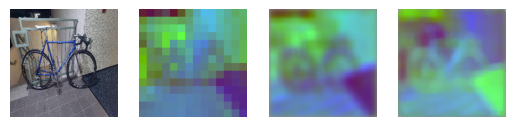

In [2]:
import torch
from transformers import ViTImageProcessor, ViTModel, ViTMAEModel
from torchvision import transforms
import math
import matplotlib.pyplot as plt
import argparse
import torchvision
import timm

imagefile='test.jpg'
pretrain='mae'

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

pt = ['imagenet', 'mae', 'dino', 'clip', 'sam']
model_paths = ['vit_base_patch16_224.augreg_in1k', 'vit_base_patch16_224.mae','vit_base_patch16_224.dino',
               'vit_base_patch16_clip_224.openai','samvit_base_patch16.sa1b']
model_path = model_paths[pt.index(pretrain)]

vit_model = timm.create_model(model_path, pretrained=True).eval().cuda()
if pretrain == 'sam':
    vit_model.neck[3].register_forward_hook(get_activation('out'))
else:
    vit_model.norm.register_forward_hook(get_activation('out'))

dataset = ImageDataset(imagefile, [224, 224])
image = dataset.dataloader[0][0].unsqueeze(0).cuda()

with torch.no_grad():
    aug_list = []

    aug_list.append(image)
    for i in range(-6,7,2):
        for j in range(-6,7,2):
            aug_list.append(transforms.functional.affine(image, translate=[i,j], angle=0, scale=1, shear=0))
    image_batch = torch.cat(aug_list, dim=0)
    b, _, h, w = image_batch.shape

    activation_list = []
    for iter in range(math.ceil(b/40)):
        activation = {}
        _ = vit_model(image_batch[iter*40:min(iter*40+40,b),:,:,:])
        activation_list.append(activation['out'])

    activation_full = torch.cat(activation_list, dim=0)

    if pretrain == 'sam':
        #feature_field = activation_full.permute(0,3,1,2).cpu()  
        feature_field = activation_full.cpu()        
    else:
        feature_field = torch.reshape(activation_full.permute(0,2,1)[:,:,1:], [b, -1, int(h/16), int(w/16)]).cpu()

    feature_field_full = torch.nn.functional.interpolate(feature_field, scale_factor=16, mode='nearest')

    n, c, h, w = feature_field_full.shape

    ind = 1
    for i in range(-6,7,2):
        for j in range(-6,7,2):
            feature_field_full[ind:ind+1, :, :, :] = transforms.functional.affine(feature_field_full[ind:ind+1, :, :, :], translate=[-i,-j], angle=0, scale=1, shear=0)
            ind += 1

    del vit_model    
    torch.cuda.empty_cache()

    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4)


    # print(feature_field_full.shape)
    feature_fine_median, _ = torch.median(feature_field_full, dim=0)
    feature_fine_median = feature_fine_median.view(-1, h*w)
    feature_fine_mean = torch.mean(feature_field_full, dim=0).view(-1, h*w)
    feature_single = feature_field_full[0, :, :].view(-1, h*w)



    # mean
    U, S, V = torch.pca_lowrank(feature_fine_mean.cuda(), q=3)

    pca_vis = V.view(h,w,3)
    pca_vis_min = torch.min(pca_vis)
    pca_vis_max = torch.max(pca_vis)
    outmap = (pca_vis - pca_vis_min) / (pca_vis_max - pca_vis_min) 
    ax3.imshow(outmap.detach().cpu().numpy())
    ax3.axis("off")
    # median
    U, S, V = torch.pca_lowrank(feature_fine_median.cuda(), q=3)

    pca_vis = V.view(h,w,3)
    pca_vis_min = torch.min(pca_vis)
    pca_vis_max = torch.max(pca_vis)
    outmap = (pca_vis - pca_vis_min) / (pca_vis_max - pca_vis_min) 
    ax4.imshow(outmap.detach().cpu().numpy())
    ax4.axis("off")

    # single    
    U, S, V = torch.pca_lowrank(feature_single.cuda(), q=3)

    pca_vis = V.view(h,w,3)
    pca_vis_min = torch.min(pca_vis)
    pca_vis_max = torch.max(pca_vis)
    outmap = (pca_vis - pca_vis_min) / (pca_vis_max - pca_vis_min) 
    ax2.imshow(outmap.detach().cpu().numpy())
    ax2.axis("off")

    image_org = (image_batch[0:1,:,:,:] - torch.min(image))/(torch.max(image) - torch.min(image))
    ax1.imshow(image_org.squeeze().permute(1,2,0).detach().cpu().numpy())
    ax1.axis("off")
    plt.show()

/media/home/ycwu/miniconda3/envs/dinov2-extras/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([50, 768, 224, 224])
torch.Size([50176, 768])
(50176, 3)
torch.Size([768, 14, 14])
(196, 3)


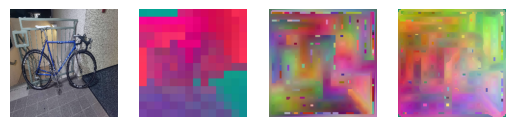

In [8]:
import torch
from transformers import ViTImageProcessor, ViTModel, ViTMAEModel
from torchvision import transforms
import math
import matplotlib.pyplot as plt
import argparse
import torchvision
import timm
import umap
import numpy as np
from PIL import Image

umap_n_neighbor=2000
umap_min_dist=1


imagefile='test.jpg'
pretrain='mae'

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

pt = ['imagenet', 'mae', 'dino', 'clip', 'sam']
model_paths = ['vit_base_patch16_224.augreg_in1k', 'vit_base_patch16_224.mae','vit_base_patch16_224.dino',
               'vit_base_patch16_clip_224.openai','samvit_base_patch16.sa1b']
model_path = model_paths[pt.index(pretrain)]

vit_model = timm.create_model(model_path, pretrained=True).eval().cuda()
if pretrain == 'sam':
    vit_model.neck[3].register_forward_hook(get_activation('out'))
else:
    vit_model.norm.register_forward_hook(get_activation('out'))

dataset = ImageDataset(imagefile, [224, 224])
image = dataset.dataloader[0][0].unsqueeze(0).cuda()

with torch.no_grad():
    aug_list = []

    aug_list.append(image)
    for i in range(-6,7,2):
        for j in range(-6,7,2):
            aug_list.append(transforms.functional.affine(image, translate=[i,j], angle=0, scale=1, shear=0))
    image_batch = torch.cat(aug_list, dim=0)
    b, _, h, w = image_batch.shape

    activation_list = []
    for iter in range(math.ceil(b/40)):
        activation = {}
        _ = vit_model(image_batch[iter*40:min(iter*40+40,b),:,:,:])
        activation_list.append(activation['out'])

    activation_full = torch.cat(activation_list, dim=0)

    if pretrain == 'sam':
        #feature_field = activation_full.permute(0,3,1,2).cpu()  
        feature_field = activation_full.cpu()        
    else:
        feature_field = torch.reshape(activation_full.permute(0,2,1)[:,:,1:], [b, -1, int(h/16), int(w/16)]).cpu()

    feature_field_full = torch.nn.functional.interpolate(feature_field, scale_factor=16, mode='nearest')

    n, c, h, w = feature_field_full.shape

    ind = 1
    for i in range(-6,7,2):
        for j in range(-6,7,2):
            feature_field_full[ind:ind+1, :, :, :] = transforms.functional.affine(feature_field_full[ind:ind+1, :, :, :], translate=[-i,-j], angle=0, scale=1, shear=0)
            ind += 1

    del vit_model    
    torch.cuda.empty_cache()

    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4)


    print(feature_field_full.shape)
    feature_fine_median, _ = torch.median(feature_field_full, dim=0)
    feature_fine_median = feature_fine_median.contiguous().view(-1, h*w).permute(1,0)
    feature_fine_mean = torch.mean(feature_field_full, dim=0).contiguous().view(-1, h*w).permute(1,0)
    feature_single = feature_field_full[0, :, :].contiguous().view(-1, h*w).permute(1,0)



    # mean
    reducer_mean = umap.UMAP(n_neighbors=umap_n_neighbor, n_components=3, min_dist=umap_min_dist)
    print(feature_fine_mean.shape)
    feat = reducer_mean.fit_transform(feature_fine_mean.cpu().numpy())
    print(feat.shape)

    pca_vis = feat.reshape(h,w,3)
    pca_vis_min = np.min(pca_vis)
    pca_vis_max = np.max(pca_vis)
    outmap = (pca_vis - pca_vis_min) / (pca_vis_max - pca_vis_min) 
    ax3.imshow(outmap)
    ax3.axis("off")
    # median
    reducer_median = umap.UMAP(n_neighbors=umap_n_neighbor, n_components=3, min_dist=umap_min_dist)
    feat = reducer_median.fit_transform(feature_fine_median.cpu().numpy())

    pca_vis = feat.reshape(h,w,3)
    pca_vis_min = np.min(pca_vis)
    pca_vis_max = np.max(pca_vis)
    outmap = (pca_vis - pca_vis_min) / (pca_vis_max - pca_vis_min) 
    ax4.imshow(outmap)
    ax4.axis("off")

    # single    
    print(feature_field[0, :, :].shape)
    reducer_single = umap.UMAP(n_neighbors=10, n_components=3, min_dist=0.1)
    feat = reducer_single.fit_transform(feature_field[0, :, :].cpu().numpy().reshape(-1, 14*14).transpose())
    print(feat.shape)
    pca_vis = feat.reshape(14,14,3)
    pca_vis_min = np.min(pca_vis)
    pca_vis_max = np.max(pca_vis)
    outmap = (pca_vis - pca_vis_min) / (pca_vis_max - pca_vis_min) 
    outmap = Image.fromarray(np.uint8(outmap*255))
    outmap = outmap.resize((224,224), 0)
    ax2.imshow(outmap)
    ax2.axis("off")

    image_org = (image_batch[0:1,:,:,:] - torch.min(image))/(torch.max(image) - torch.min(image))
    ax1.imshow(image_org.squeeze().permute(1,2,0).detach().cpu().numpy())
    ax1.axis("off")
    plt.show()